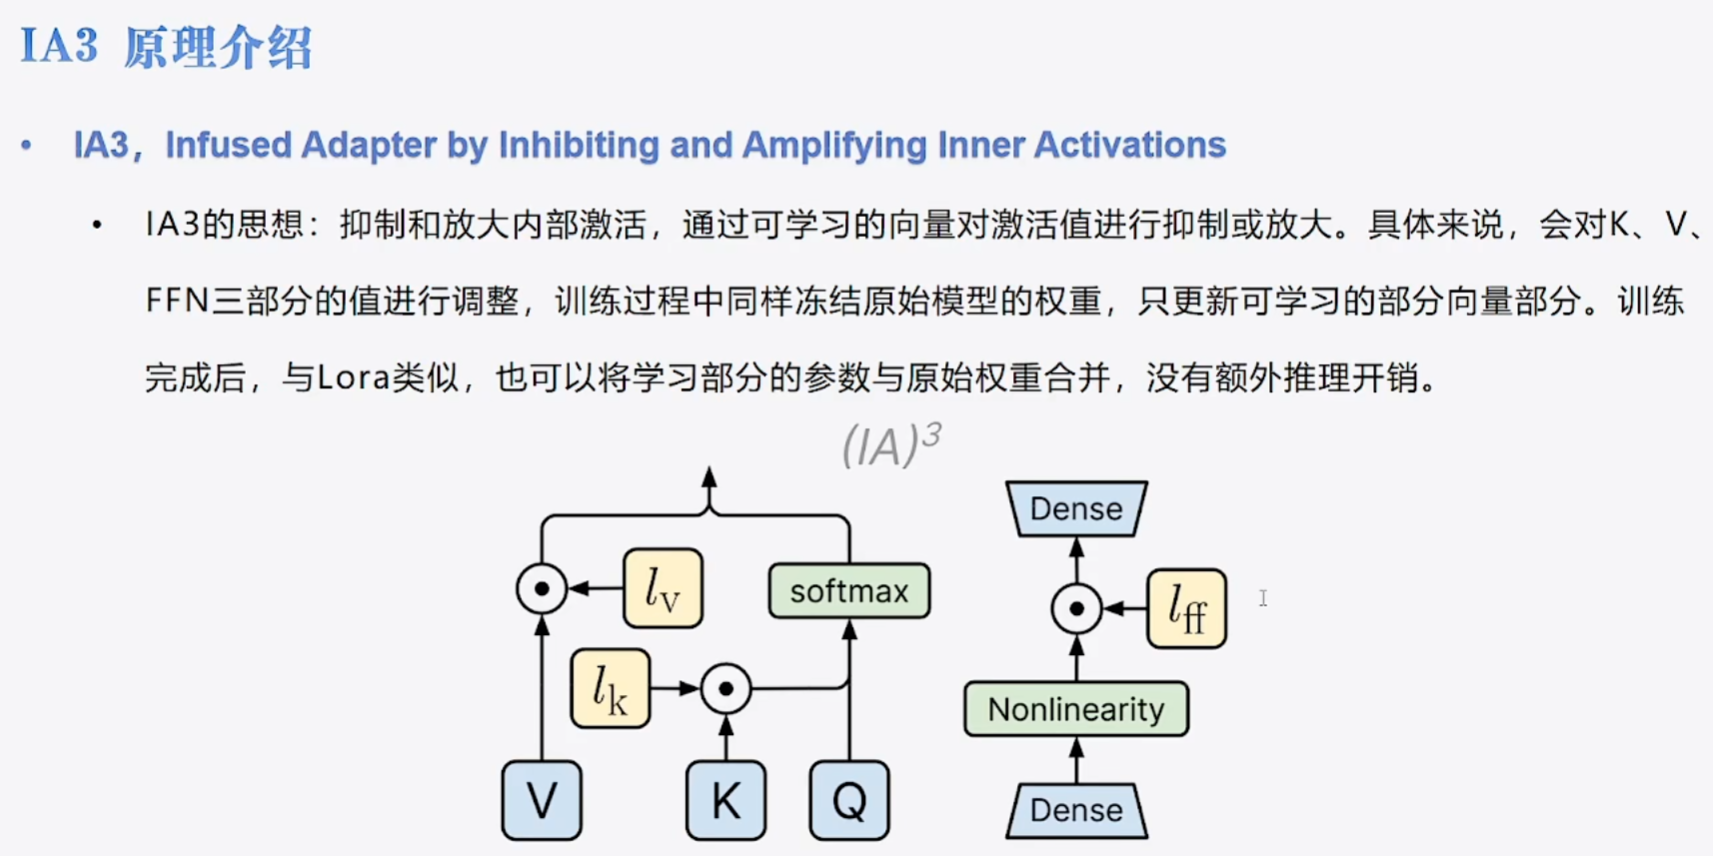

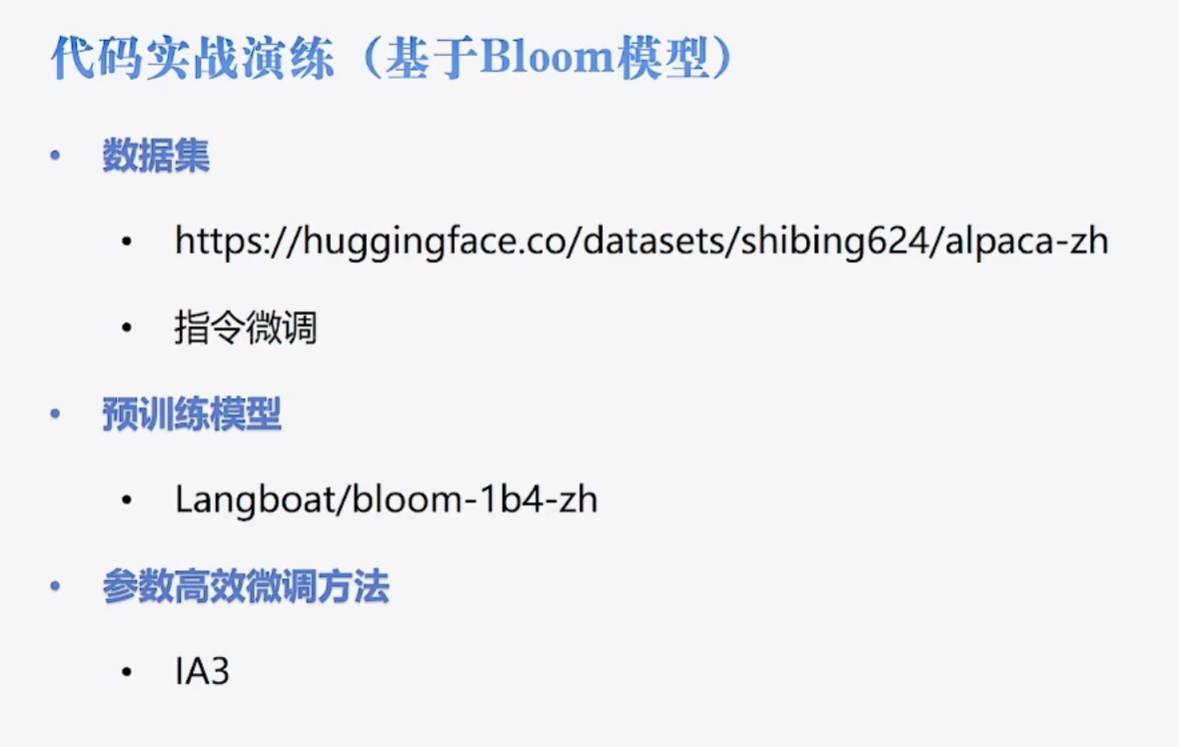

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [2]:
ds = Dataset.load_from_disk("./alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-1b4-zh")
tokenizer

D:\Environment\Python\python3.10\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BloomTokenizerFast(name_or_path='Langboat/bloom-1b4-zh', vocab_size=46145, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [6]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-1b4-zh", low_cpu_mem_usage=True)

# IA3

### Step1 配置文件

In [7]:
from peft import IA3Config,TaskType,get_peft_model

In [9]:
config = IA3Config(task_type=TaskType.CAUSAL_LM)
config

IA3Config(peft_type=<PeftType.IA3: 'IA3'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, target_modules=None, feedforward_modules=None, fan_in_fan_out=False, modules_to_save=None, init_ia3_weights=True)

### Step2 创建模型

In [10]:
model=get_peft_model(model,config)

In [11]:
for name,param in model.named_parameters():
    print(name)

base_model.model.transformer.word_embeddings.weight
base_model.model.transformer.word_embeddings_layernorm.weight
base_model.model.transformer.word_embeddings_layernorm.bias
base_model.model.transformer.h.0.input_layernorm.weight
base_model.model.transformer.h.0.input_layernorm.bias
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.weight
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.bias
base_model.model.transformer.h.0.self_attention.query_key_value.ia3_l.default
base_model.model.transformer.h.0.self_attention.dense.weight
base_model.model.transformer.h.0.self_attention.dense.bias
base_model.model.transformer.h.0.post_attention_layernorm.weight
base_model.model.transformer.h.0.post_attention_layernorm.bias
base_model.model.transformer.h.0.mlp.dense_h_to_4h.weight
base_model.model.transformer.h.0.mlp.dense_h_to_4h.bias
base_model.model.transformer.h.0.mlp.dense_4h_to_h.base_layer.weight
base_model.model.transformer.h.0.mlp.dense_4h

In [12]:
model.print_trainable_parameters()

trainable params: 344,064 || all params: 1,303,455,744 || trainable%: 0.0264


---

In [ ]:
args = TrainingArguments(
    output_dir="./lora-tuning",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)